### SQL-Abfragen in Relationale Algebra konvertieren

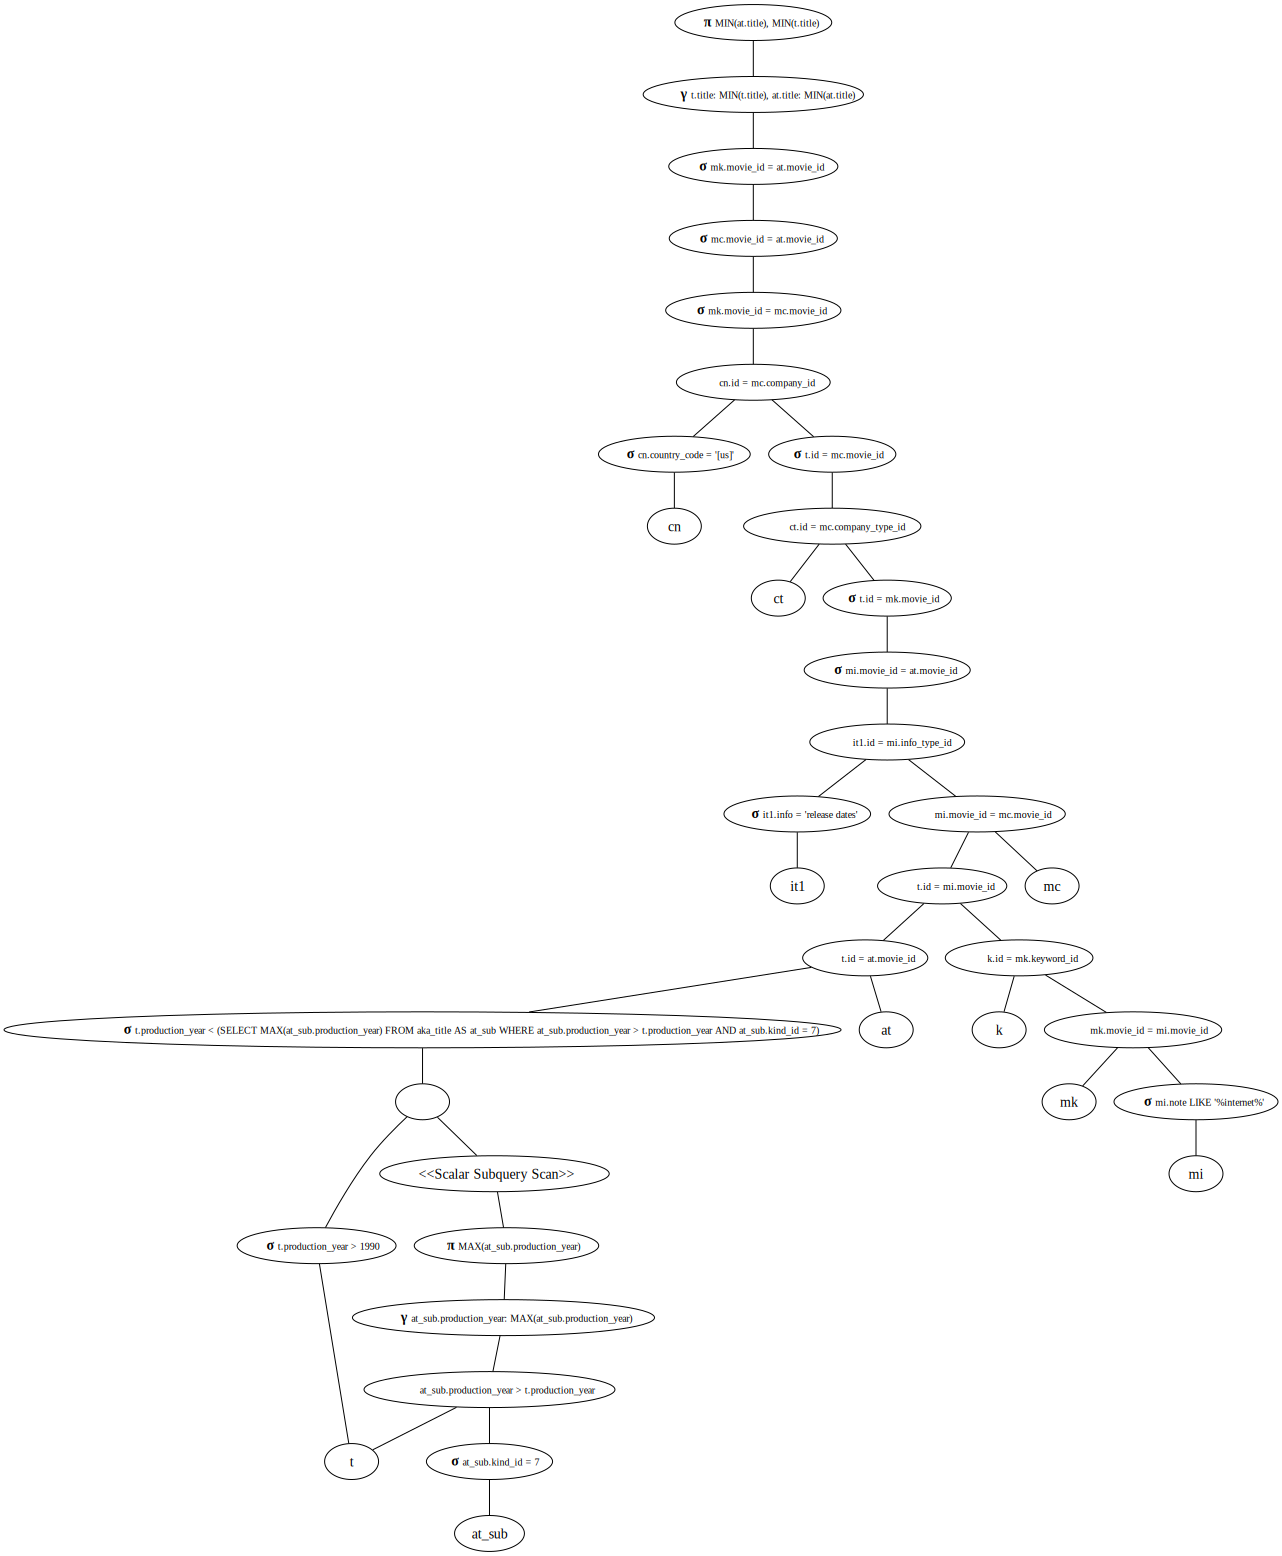

In [9]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

sql_query_3 = "SELECT MIN(at.title) AS aka_title, MIN(t.title) AS internet_movie_title FROM aka_title AS at, company_name AS cn, company_type AS ct, info_type AS it1, keyword AS k, movie_companies AS mc, movie_info AS mi, movie_keyword AS mk, title AS t WHERE cn.country_code = '[us]' AND it1.info = 'release dates' AND mi.note LIKE '%internet%' AND t.production_year > 1990 AND t.id = at.movie_id AND t.id = mi.movie_id AND t.id = mk.movie_id AND t.id = mc.movie_id AND mk.movie_id = mi.movie_id AND mk.movie_id = mc.movie_id AND mk.movie_id = at.movie_id AND mi.movie_id = mc.movie_id AND mi.movie_id = at.movie_id AND mc.movie_id = at.movie_id AND k.id = mk.keyword_id AND it1.id = mi.info_type_id AND cn.id = mc.company_id AND ct.id = mc.company_type_id AND t.production_year < (SELECT MAX(at_sub.production_year) FROM aka_title AS at_sub WHERE at_sub.production_year > t.production_year AND at_sub.kind_id = 7)"

sql_query_4 = "SELECT MIN(cn.name) AS movie_company, MIN(mi_idx.info) AS rating, MIN(t.title) AS complete_euro_dark_movie FROM complete_cast AS cc, comp_cast_type AS cct1, comp_cast_type AS cct2, company_name AS cn, company_type AS ct, info_type AS it1, info_type AS it2, keyword AS k, kind_type AS kt, movie_companies AS mc, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, title AS t WHERE cct1.kind = 'crew' AND cct2.kind != 'complete+verified' AND cn.country_code != '[us]' AND it1.info = 'countries' AND it2.info = 'rating' AND k.keyword IN ('murder', 'murder-in-title', 'blood', 'violence') AND kt.kind IN ('movie', 'episode') AND mc.note NOT LIKE '%(USA)%' AND mc.note LIKE '%(200%)%' AND mi.info IN ('Sweden', 'Norway', 'Germany', 'Denmark', 'Swedish', 'Danish', 'Norwegian', 'German', 'USA', 'American') AND mi_idx.info < '8.5' AND t.production_year > 2000 AND kt.id = t.kind_id AND t.id = mi.movie_id AND t.id = mk.movie_id AND t.id = mi_idx.movie_id AND t.id = mc.movie_id AND t.id = cc.movie_id AND mk.movie_id = mi.movie_id AND mk.movie_id = mi_idx.movie_id AND mk.movie_id = mc.movie_id AND mk.movie_id = cc.movie_id AND mi.movie_id = mi_idx.movie_id AND mi.movie_id = mc.movie_id AND mi.movie_id = cc.movie_id AND mc.movie_id = mi_idx.movie_id AND mc.movie_id = cc.movie_id AND mi_idx.movie_id = cc.movie_id AND k.id = mk.keyword_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND ct.id = mc.company_type_id AND cn.id = mc.company_id AND cct1.id = cc.subject_id AND cct2.id = cc.status_id"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)
relalg_query_3 = parser.parse_relalg(sql_query_3)
relalg_query_4 = parser.parse_relalg(sql_query_4)
opt_vis.plot_relalg(relalg_query_3)

### Optimierung

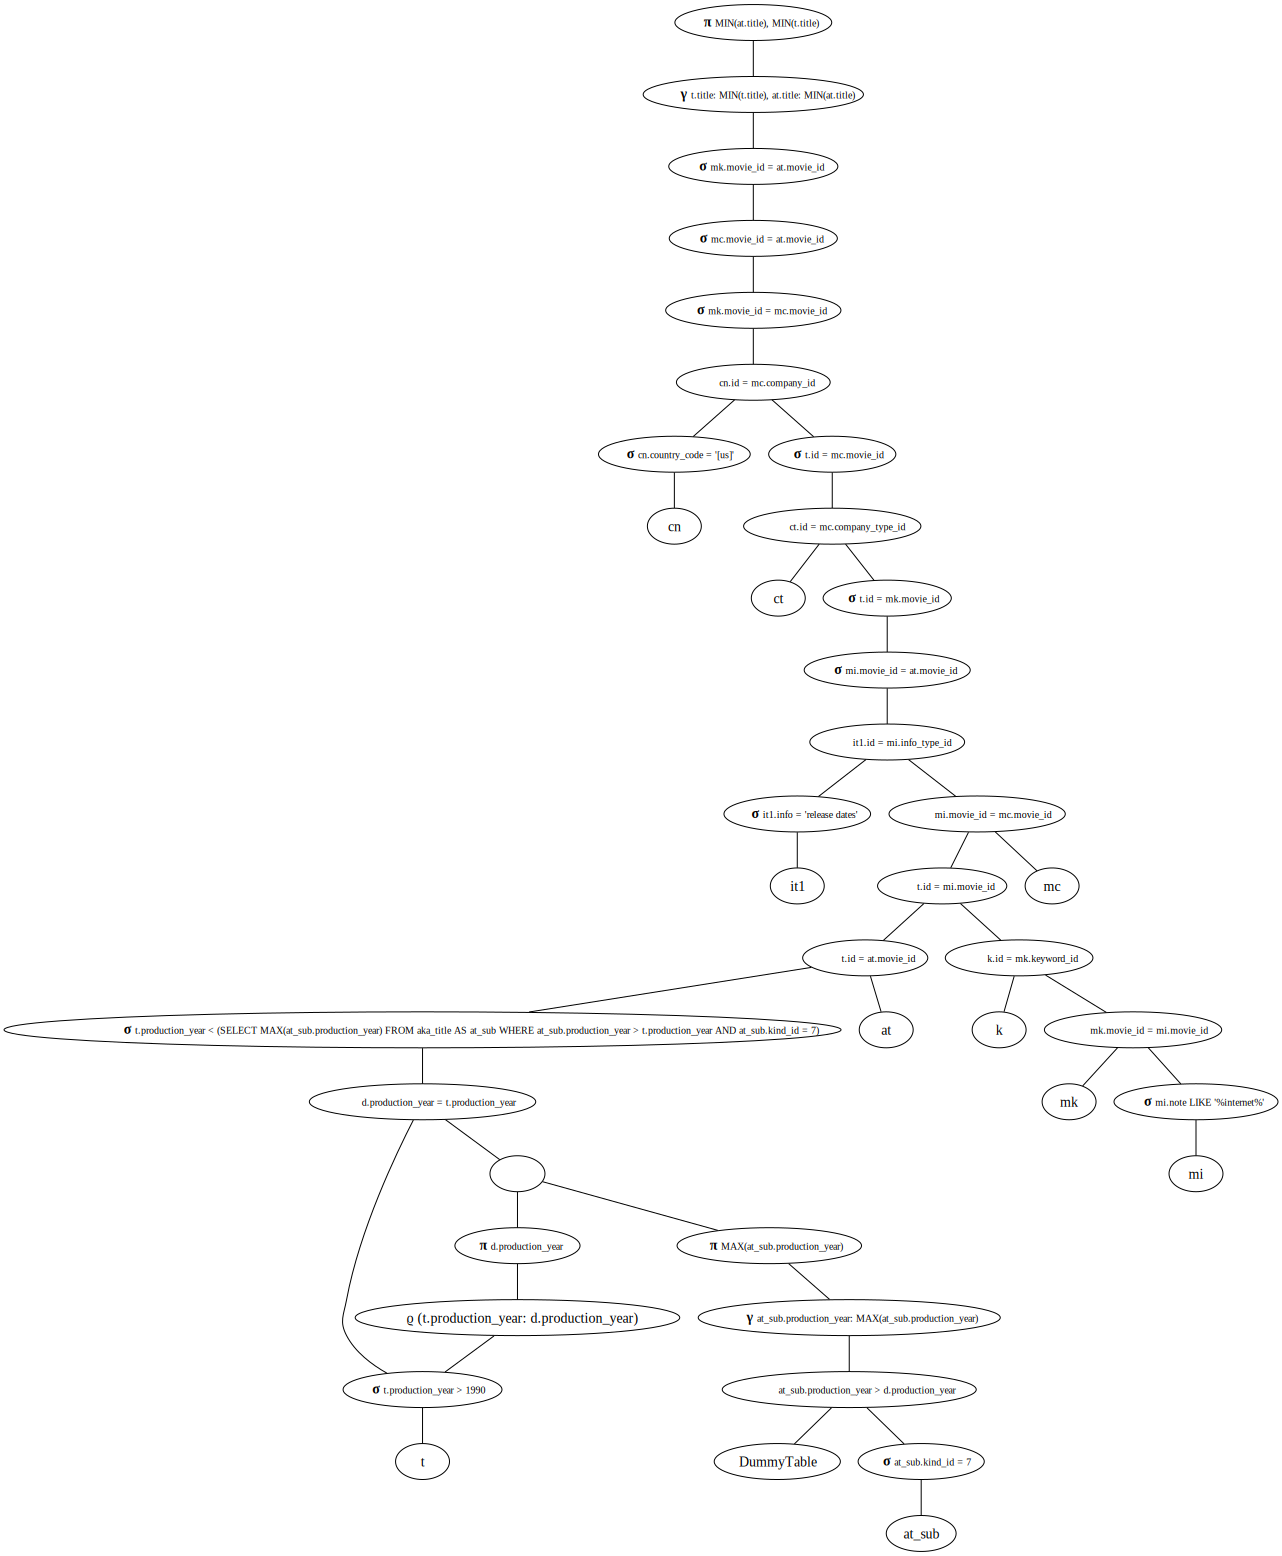

In [10]:
from src.utils.utils import Utils
from src.optimizer.push_down_manager import PushDownManager
from src.optimizer.optimizer import Optimizer

utils = Utils()
pushDownManager = PushDownManager(utils)
optimizer = Optimizer(utils)
result = optimizer.optimize_unnesting(relalg_query_3)

opt_vis.plot_relalg(result)


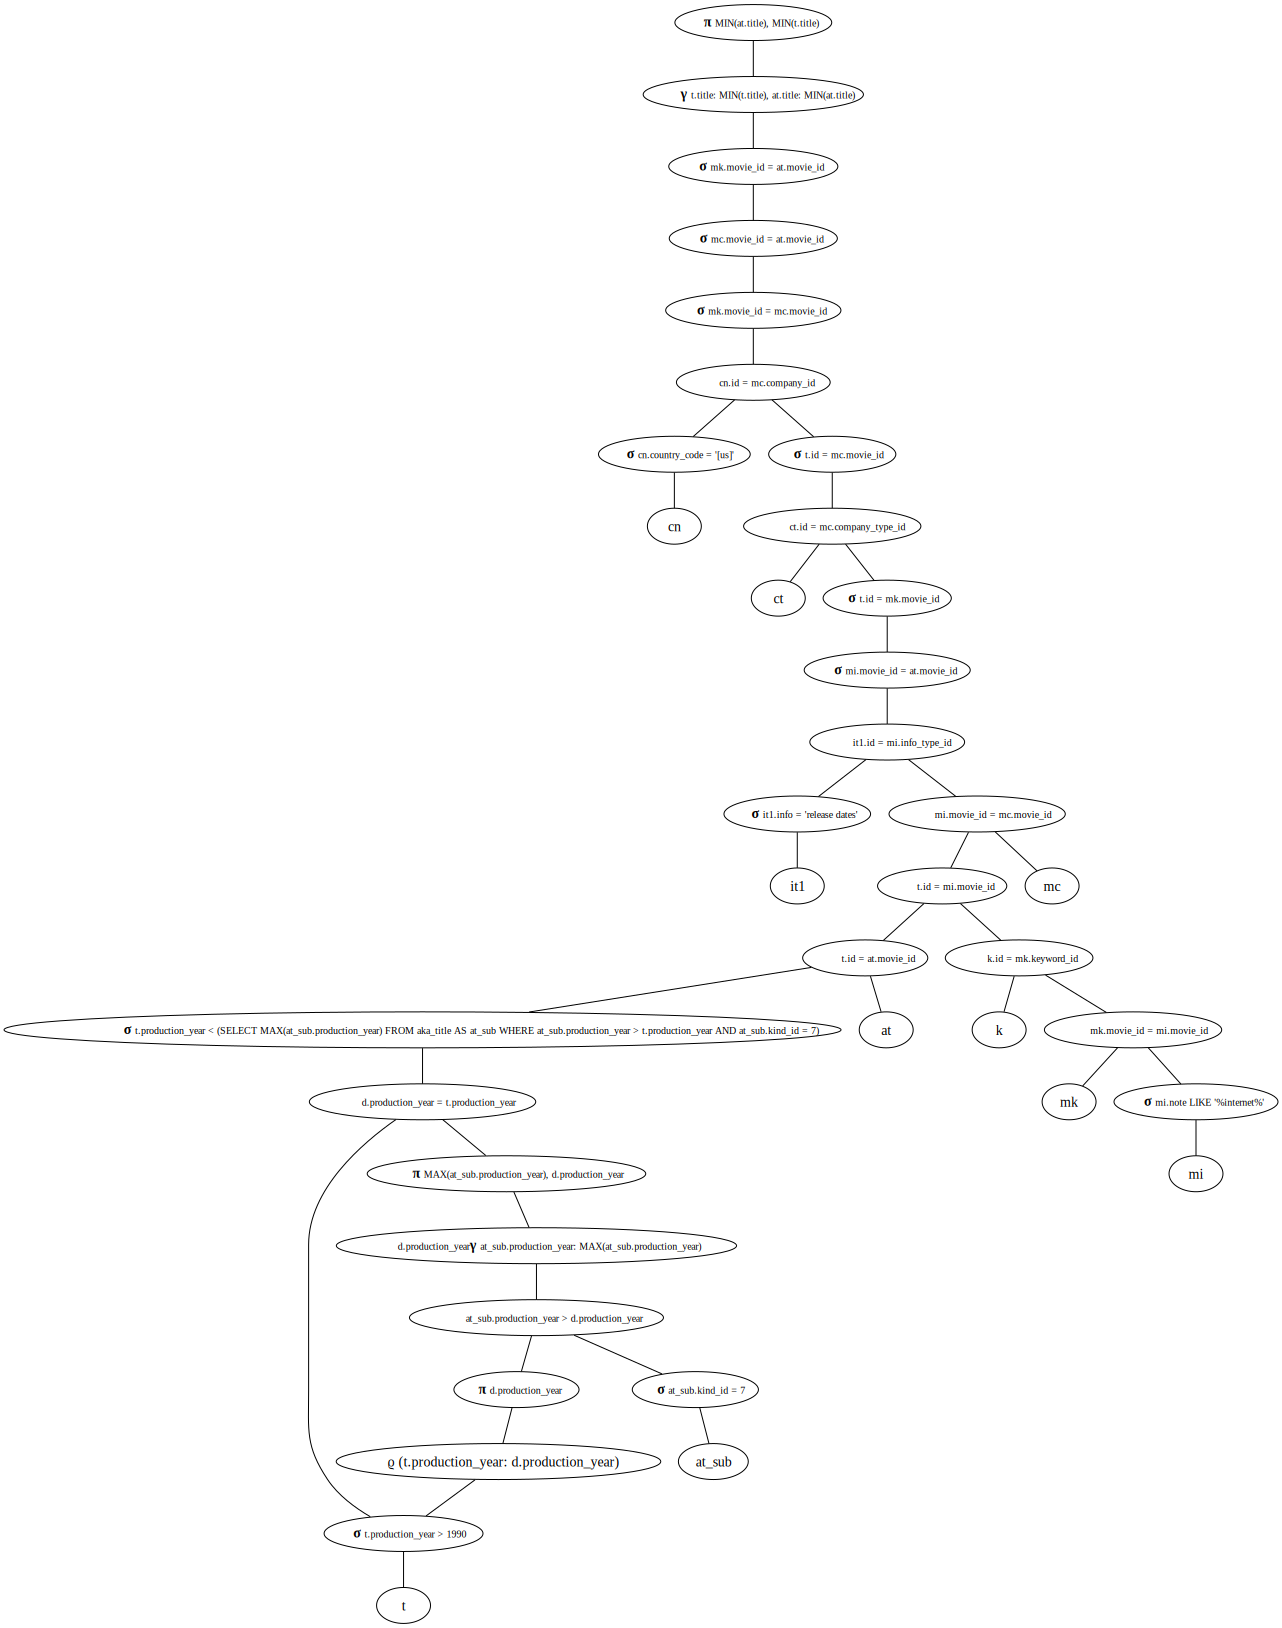

In [11]:
push_down, subquery_root = pushDownManager.push_down(result)
opt_vis.plot_relalg(push_down)

In [12]:
from postbound.qal import formatter
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
final_query = query_generator.generate_sql_from_relalg(push_down, subquery_root)
print(formatter.format_quick(final_query))

WITH outerquery AS (
  SELECT t.title, t.id, t.production_year
  FROM title AS t
  WHERE t.production_year > 1990
), dup_elim_outerquery AS (
  SELECT DISTINCT production_year
  FROM outerquery
)
SELECT MIN(at.title), MIN(oq.title)
FROM outerquery AS oq, company_name AS cn, company_type AS ct, info_type AS it1, movie_companies AS mc, aka_title AS at, keyword AS k, movie_keyword AS mk, movie_info AS mi, (SELECT MAX(at_sub.production_year) AS m1, d.production_year FROM dup_elim_outerquery AS d, aka_title AS at_sub WHERE at_sub.production_year > d.production_year AND at_sub.kind_id = 7 GROUP BY d.production_year) AS subquery
WHERE mk.movie_id = at.movie_id AND mc.movie_id = at.movie_id AND mk.movie_id = mc.movie_id AND cn.id = mc.company_id AND cn.country_code = '[us]' AND oq.id = mc.movie_id AND ct.id = mc.company_type_id AND oq.id = mk.movie_id AND mi.movie_id = at.movie_id AND it1.id = mi.info_type_id AND it1.info = 'release dates' AND mi.movie_id = mc.movie_id AND oq.id = mi.movie_id 